In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten,Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')
df = pd.read_csv("指數.csv", encoding="utf-8").drop(['id'], axis=1)
df['vol'] = df['vol'].replace({',': ''}, regex=True).astype(float)

In [63]:
df.sort_values("time", inplace=True)
df['time'] = pd.to_datetime(df['time'], format='%Y/%m/%d')
df = df.set_index("time")
df.head()

,close,vol
time,,
2024-01-02,149.44,73531.0
2024-01-03,148.24,77810.0
2024-01-04,147.46,102989.0
2024-01-05,147.41,83374.0
2024-01-08,148.58,124954.0


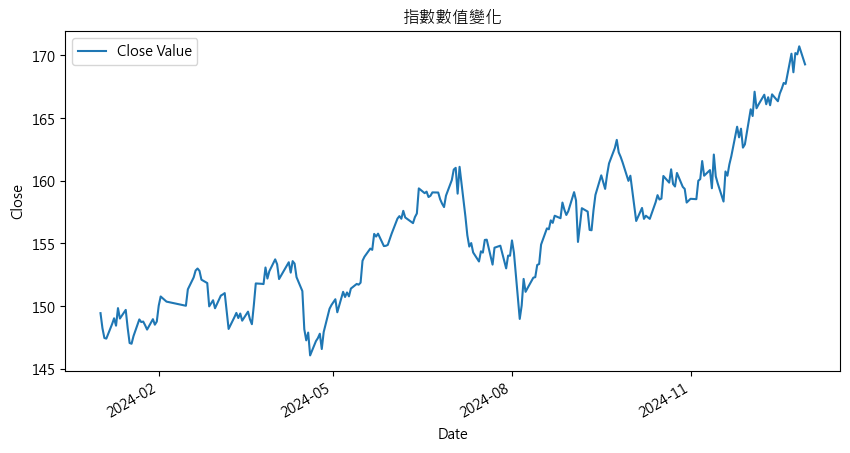

In [64]:
import matplotlib.dates as mdates
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close'], label="Close Value")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("指數數值變化")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 每3個月顯示一次標籤
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate() 
plt.show()

In [90]:
def create_dataset(dataset, look_back=5):
    dataX , dataY = [] , []
    for i in range(len(dataset) - look_back + 1):  
        segment = dataset.iloc[i:i + look_back].values.tolist()  # 提取資料片段並轉為列表
        result = dataset.iloc[i + look_back - 1, 0]  
        dataX.append(segment)
        dataY.append(result)
    return np.array(dataX), np.array(dataY)
look_back = 10
train_size = 200
X, y= create_dataset(df, look_back)
X_train, y_train, X_test, y_test = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

In [92]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(200, 10, 2) (200,) (32, 10, 2) (32,)


In [94]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [106]:
# 第1個模型 - MLP
model_mlp = Sequential([
    Flatten(input_shape=(look_back, X.shape[-1])),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1),
])
model_mlp.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
model_mlp.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
7/7 [==============================] - 0s 5ms/step - loss: 0.8796
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.8083
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.7142
Epoch 4/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6393
Epoch 5/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6191
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 0.5157
Epoch 7/50
7/7 [==============================] - 0s 6ms/step - loss: 0.4725
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.4298
Epoch 9/50
7/7 [==============================] - 0s 9ms/step - loss: 0.4111
Epoch 10/50
7/7 [==============================] - 0s 6ms/step - loss: 0.3002
Epoch 11/50
7/7 [==============================] - 0s 6ms/step - loss: 0.3213
Epoch 12/50
7/7 [==============================] - 0s 6ms/step - loss: 0.2631
Epoch 13/50
7/7 [==============================] - 0s 5ms/step - loss: 0.

In [96]:
# 第2個模型 - LSTM
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[-1])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
model_lstm.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
7/7 [==============================] - 3s 12ms/step - loss: 0.2174
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.1769
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.1401
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 0.1107
Epoch 5/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0827
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0558
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0342
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0212
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0182
Epoch 11/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0192
Epoch 12/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0173
Epoch 13/50
7/7 [==============================] - 0s 8ms/step - loss

In [97]:
# 第3個模型 - 堆疊 BiLSTM
model_bilstm = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(look_back, X.shape[-1])),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.2),
    Dense(1)
])
model_bilstm.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
model_bilstm.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
7/7 [==============================] - 6s 34ms/step - loss: 0.2691
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.1049
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0248
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0225
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0214
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0127
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0133
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0138
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0118
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0122
Epoch 11/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0111
Epoch 12/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0103
Epoch 13/50
7/7 [==============================] - 0s 14ms/st

In [107]:
pred_lstm = model_lstm.predict(X_test_scaled)
pred_mlp = model_mlp.predict(X_test_scaled)
pred_bilstm = model_bilstm.predict(X_test_scaled)

mse_mlp = np.mean((y_test_scaled - pred_mlp) ** 2)
mse_lstm = np.mean((y_test_scaled - pred_lstm) ** 2)
mse_bilstm = np.mean((y_test_scaled - pred_bilstm) ** 2)

print("MLP MSE:", mse_mlp)
print("LSTM MSE:", mse_lstm)
print("BiLSTM MSE:", mse_bilstm)

1/1 [==============================] - 0s 89ms/step
MLP MSE: 0.01120048472476158
LSTM MSE: 0.009214387868549634
BiLSTM MSE: 0.004599618793885854


In [108]:
print(pred_lstm.shape, pred_mlp.shape, pred_bilstm.shape, df.shape)

(32, 1) (32, 1) (32, 1) (241, 2)


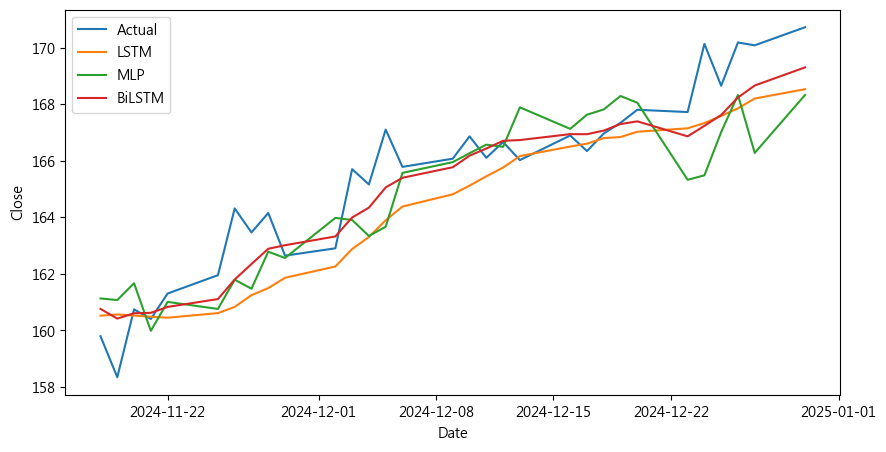

In [109]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plot_length = min(len(y_test_scaled), len(pred_lstm), len(pred_mlp), len(pred_bilstm)-1)

df.index = pd.to_datetime(df.index)
plt.figure(figsize=(10, 5))
plt.plot(df.index[train_size+look_back:train_size+look_back+plot_length], scaler_y.inverse_transform(y_test_scaled[:plot_length]), label="Actual")
plt.plot(df.index[train_size+look_back:train_size+look_back+plot_length], scaler_y.inverse_transform(pred_lstm[:plot_length]), label="LSTM")
plt.plot(df.index[train_size+look_back:train_size+look_back+plot_length], scaler_y.inverse_transform(pred_mlp[:plot_length]), label="MLP")
plt.plot(df.index[train_size+look_back:train_size+look_back+plot_length], scaler_y.inverse_transform(pred_bilstm[:plot_length]), label="BiLSTM")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
# 格式化日期顯示，設置標籤間隔
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 每3個月顯示一次標籤
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gcf().autofmt_xdate() 
plt.show()